Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[0]	validation_0-rmse:1916.11278	validation_1-rmse:1845.04095
[1]	validation_0-rmse:1758.33236	validation_1-rmse:1691.12227
[2]	validation_0-rmse:1617.71688	validation_1-rmse:1556.46520
[3]	validation_0-rmse:1493.63433	validation_1-rmse:1437.38679
[4]	validation_0-rmse:1383.28796	validation_1-rmse:1334.66050
[5]	validation_0-rmse:1285.88614	validation_1-rmse:1244.72931
[6]	validation_0-rmse:1200.03505	validation_1-rmse:1167.48482
[7]	validation_0-rmse:1124.48424	validation_1-rmse:1097.83789
[8]	validation_0-rmse:1057.67491	validation_1-rmse:1038.62562
[9]	validation_0-rmse:999.56267	validation_1-rmse:986.04897
[10]	validation_0-rmse:949.12376	validation_1-rmse:943.63622
[11]	validation_0-rmse:903.26816	validation_1-rmse:905.15303
[12]	validation_0-rmse:864.30631	validation_1-rmse:875.83230
[13]	validation_0-rmse:829.29743	validation_1-rmse:849.31440
[14]	vali

/usr/local/lib/python3.11/dist-packages/xgboost/callback.py:386: UserWarning: [17:18:11] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()


[22]	validation_0-rmse:661.17600	validation_1-rmse:737.80226
[23]	validation_0-rmse:651.65068	validation_1-rmse:732.89633
[24]	validation_0-rmse:643.16024	validation_1-rmse:728.82269
[25]	validation_0-rmse:636.29036	validation_1-rmse:725.02046
[26]	validation_0-rmse:630.13330	validation_1-rmse:722.15010
[27]	validation_0-rmse:624.54653	validation_1-rmse:719.14344
[28]	validation_0-rmse:619.32461	validation_1-rmse:716.35224
[29]	validation_0-rmse:613.69800	validation_1-rmse:713.62952
[30]	validation_0-rmse:609.84303	validation_1-rmse:711.68938
[31]	validation_0-rmse:605.81795	validation_1-rmse:710.51050
[32]	validation_0-rmse:601.78950	validation_1-rmse:710.00151
[33]	validation_0-rmse:597.78941	validation_1-rmse:709.40518
[34]	validation_0-rmse:594.17501	validation_1-rmse:708.31813
[35]	validation_0-rmse:590.93313	validation_1-rmse:707.51828
[36]	validation_0-rmse:587.07087	validation_1-rmse:706.61743
[37]	validation_0-rmse:584.11183	validation_1-rmse:706.38477
[38]	validation_0-rmse:5

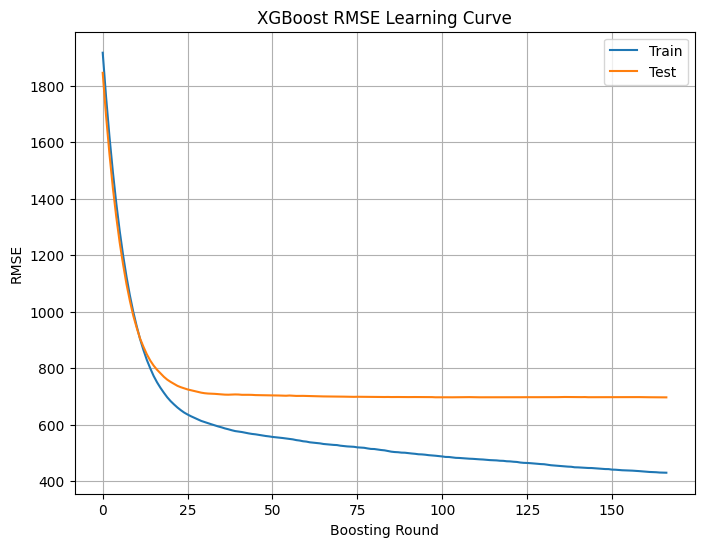


Initial Model Performance:
RMSE: 696.88
R² Score: 0.88
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [17:19:59] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Best Parameters: {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [17:19:59] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Best Model Performance:
RMSE: 698.15
R² Score: 0.88
MAE: 293.80


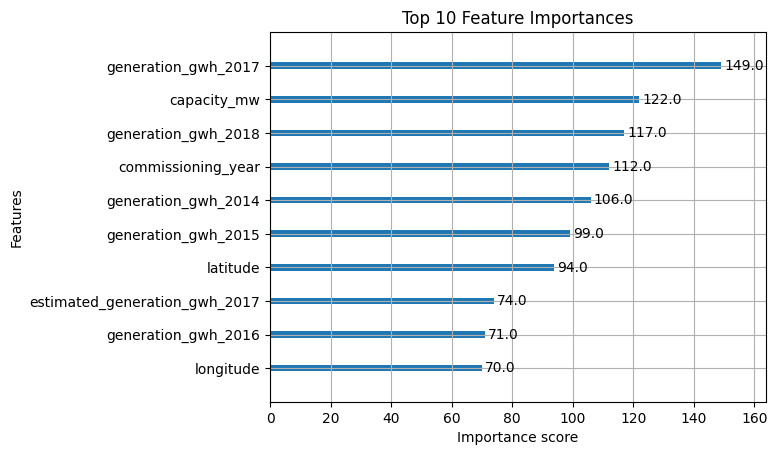

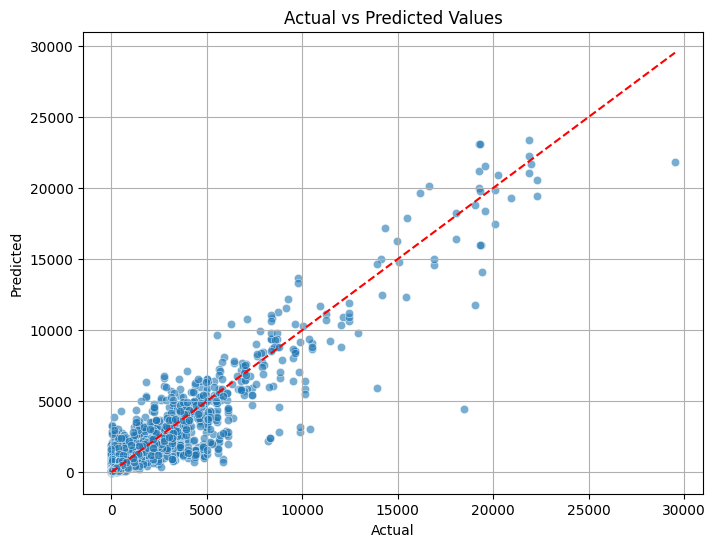

In [ ]:
# === [1] Mount Google Drive and Install Dependencies ===
from google.colab import drive
drive.mount('/content/drive')

# Install/upgrade XGBoost (critical fix)
!pip install --upgrade xgboost scikit-learn

# === [2] Imports ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# === [3] Load Data ===
train_path = '/content/drive/My Drive/Statistics Datasets/gpp_train.csv'
test_path = '/content/drive/My Drive/Statistics Datasets/gpp_test.csv'

gpp_train = pd.read_csv(train_path)
gpp_test = pd.read_csv(test_path)

# === [4] Split Features and Target ===
X_train = gpp_train.drop(columns=['generation_gwh_2019'])
y_train = gpp_train['generation_gwh_2019']  # Fix typo here if needed

X_test = gpp_test.drop(columns=['generation_gwh_2019'])
y_test = gpp_test['generation_gwh_2019']

# === [5] Preprocessing: One-Hot Encoding ===
X_train = pd.get_dummies(X_train)
X_test = pd.get_dummies(X_test)

# Align columns
X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

# === [6] Train Initial XGBoost Model with Evaluation Set ===
eval_set = [(X_train, y_train), (X_test, y_test)]

# Key fix: Move early_stopping_rounds to XGBRegressor constructor
model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=1000,
    max_depth=6,
    learning_rate=0.1,
    random_state=42,
    eval_metric='rmse',
    use_label_encoder=False,
    early_stopping_rounds=50  # Now in constructor
)

model.fit(
    X_train, y_train,
    eval_set=eval_set,
    verbose=True
)

# === [6.1] Plot Learning Curve ===
results = model.evals_result()

plt.figure(figsize=(8, 6))
plt.plot(results['validation_0']['rmse'], label='Train')
plt.plot(results['validation_1']['rmse'], label='Test')
plt.legend()
plt.xlabel("Boosting Round")
plt.ylabel("RMSE")
plt.title("XGBoost RMSE Learning Curve")
plt.grid(True)
plt.show()

# === [7] Evaluate Initial Model ===
y_pred = model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"\nInitial Model Performance:")
print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.2f}")

# === [8] Hyperparameter Tuning ===
param_grid = {
    'max_depth': [4, 6, 8],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200],
    'subsample': [0.8, 1.0]
}

grid_search = GridSearchCV(
    estimator=xgb.XGBRegressor(
        objective='reg:squarederror',
        random_state=42,
        use_label_encoder=False
    ),
    param_grid=param_grid,
    cv=3,
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_train, y_train)
print("\nBest Parameters:", grid_search.best_params_)

# === [9] Train Best Model ===
best_model = grid_search.best_estimator_
best_model.fit(X_train, y_train)

# === [10] Final Evaluation ===
y_pred_best = best_model.predict(X_test)

rmse_best = np.sqrt(mean_squared_error(y_test, y_pred_best))
r2_best = r2_score(y_test, y_pred_best)
mae_best = mean_absolute_error(y_test, y_pred_best)

print(f"\nBest Model Performance:")
print(f"RMSE: {rmse_best:.2f}")
print(f"R² Score: {r2_best:.2f}")
print(f"MAE: {mae_best:.2f}")

# === [11] Feature Importance ===
xgb.plot_importance(best_model, max_num_features=10)
plt.title("Top 10 Feature Importances")
plt.show()

# === [12] Actual vs Predicted Plot ===
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred_best, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs Predicted Values")
plt.grid(True)
plt.show()